### How does subarray sizes affect average correlation?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import StatsFunctions as statsfunc
import LSSfunctions as lssfunc
import GSMfunctions as gsmfunc

Let's first observe what is going on in our data.

In [4]:
def ccplot_subarray_sizes(sample_type, div=200, log=True, numpoints=15, centered=False):
    
    #data preparation
    z = np.linspace(0,0.5,numpoints)
    temp = gsmfunc.cctemp(log=log, freq=500, div=div, centered=centered)
    x = (z[1:] + z[:-1])/2
    subarr_size = [5,10,20,25,50,100]
    colors = ['blue', 'red', 'green', 'orange','purple','brown']
    
    #Plotting preparation
    plt.figure(figsize=(12,8))
    plt.rcParams['font.family']='serif'
    plt.rcParams['font.size']='16'
    plt.xlabel('z')
    plt.ylabel('Corr')
    plt.fill_between(x,[0.015]*len(x), [-0.015]*len(x), color='black',alpha=0.1, label='noise')

    #Retrieve data and plot
    
    for (size,color) in zip(subarr_size, colors):
        error = []
        corravg = []
        for i in range(len(z)-1):
            lssdata = lssfunc.cclss(sample_type, zmin=z[i], zmax=z[i+1], div=div, centered=centered)
            corr, err = statsfunc.correlate(temp, lssdata, subarr_size=size)
            error.append(err)
            corravg.append(corr)

        plt.plot(x,corravg,'-', color=color, label= 'subarray size of '+str(size))
        plt.errorbar(x,corravg, yerr=error,fmt='.', color=color, capsize=5, markersize=10)
    
    
    plt.legend()
    return 

It is clear that smaller subarray sizes result in smaller average correlation values. We can now explore this mathematically.

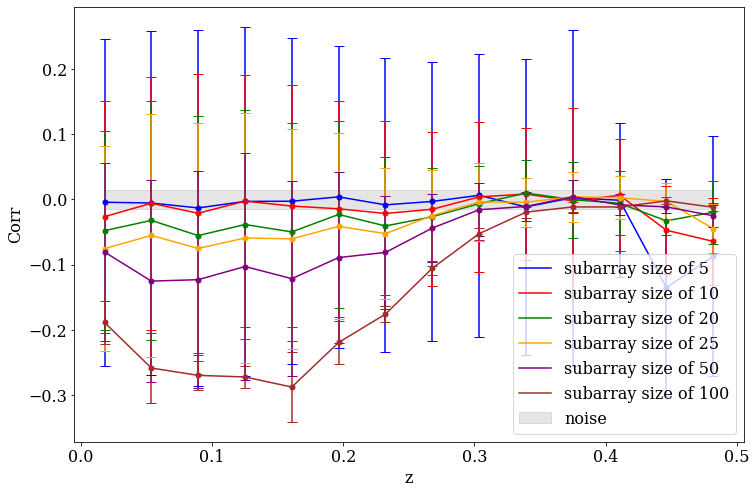

In [5]:
ccplot_subarray_sizes('bright')

Let $X = (x_{1}, x_{2}, ..., x_{m}),  Y = (y_{1}, y_{2}, ..., y_{m})$. Then, suppose we split both $X$ and $Y$ into subarrays of size $n$, totaling $\frac{m}{n}$ subarrays in both $X,Y$. We denote $X_{i}, Y_{i}$ the subarrays. Then,<br>

$ COV(X,Y) - <COV(X_{i},Y_{i})> = \big(E(X \cdot ^* Y) - E(X)E(Y)\big) - \big(<E(X_{i} \cdot ^* Y_{i})> - <E(X_{i})E(Y_{i})>\big) $<br>

But since the average of the sums equals the sum of the averages, the first and third term on the RHS cancel out. One can work this out on paper to verify (I did, future william trust me, and if you don't go see in the appendix). So we are left with 

$ COV(X,Y) - <COV(X_{i},Y_{i})> = <E(X_{i})E(Y_{i})> - E(X)E(Y) $<br>

This expression can be rewritten as sums instead of expectation values. We get:

$COV(X,Y) - <COV(X_{i},Y_{i})> =  \big(\frac{1}{nm} - \frac{1}{m^{2}} \big) \sum_{i}^{m/n} \bar{ X_{i}} \bar{ Y_{i}} - \frac{1}{m^{2}} \sum_{i}^{m/n} \sum_{j \neq i}^{m/n} \bar{ X_{i}} \bar{ Y_{j}}$<br>


Where $\bar{X_{i}} = \sum_{j}^{n} X_{i}$, i.e. the sum of all the elements in the subarray.

We can finally make observations with Gaussian distributed $X,Y$.

In [3]:
def cov(x,y):
    return np.multiply(x,y).mean() - x.mean()*y.mean()

In [112]:
def covdiff_rand():
    plt.figure(figsize=(12,10))
    #Initialize vectors X and Y
    m = 720
    ex = 3
    ey = 8
    sigx = 2.3
    sigy = 1.2
    for i in range(35):
        X = np.random.normal(loc=ex, scale=sigx, size=m) 
        Y = np.random.normal(loc=ey, scale=sigy, size=m)

        split_vals = [2,3,4,5,6,8,10,12,15,18,20,24,30,36,120]
        x = [120/i for i in split_vals]
        y = []
        for split in split_vals:
            val = cov(X,Y) - np.array([cov(xi,yi) for (xi,yi) in zip(np.split(X,split), np.split(Y,split))]).mean()
            y.append(val)

        plt.plot(x, y, label='run # '+str(i+1))
    
    
    plt.hlines(0,5,60)
    plt.ylabel('Covariance diff')
    plt.xlabel('subarray size')
    
    plt.plot(np.linspace(2,60,1000), [0.5/n for n in np.linspace(2,120,1000)], lw=5)
    plt.legend()
    return

We see that the error spreads like some 1/n tendency, where n is the subarray size.

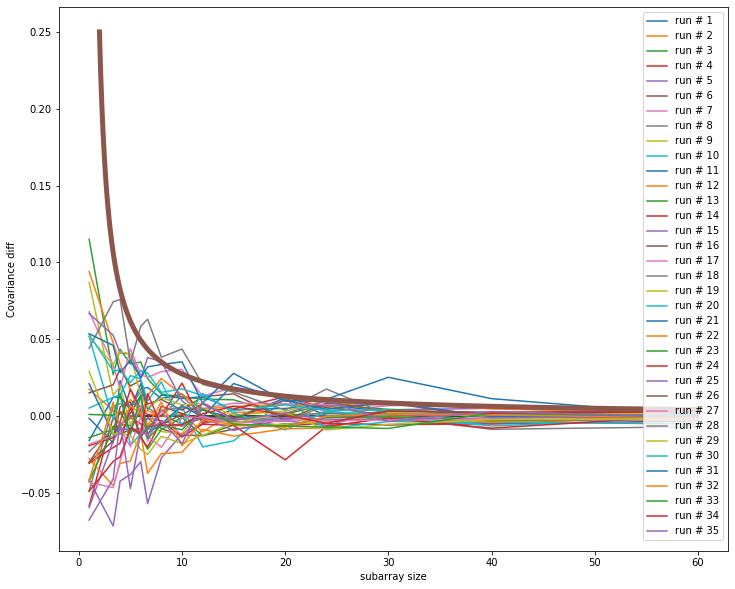

In [113]:
covdiff_rand()

From the above observations, we can make the educated guess that

$<COR(X_{i},Y_{i})> \approx COR(X,Y) + (\frac{1}{nm} - \frac{1}{m^{2}}) \cdot \delta$

where $\delta$ is some unknown factor.

In this form, the average correlation is then subject to n,m dependencies. Indeed, when n=m we get that the average correlation is just the total correlation. Moreover, smaller n gives rise to bigger discrepancies, and so the average correlation value is farther from the total correlation value. 

In [114]:
def covariate(a, b, subarr_size = 10, filter_zeros=True): #We assume both have shapes of (100,100) for simplicity. We split the array in 5x5 subarrays
    
    if a.shape != b.shape: #We want same dimensions for both matrices
        return 0
    
    if a.shape[0] != a.shape[1]: #We want square matrices
        return 0
    
    N,_ = a.shape
    corr_vals = []

    
    if N % subarr_size != 0: #We want the size of the subarray to be a multiple of the size of the whole array
        return 0
    
    step = subarr_size #This is solely to express understanding of how subarray size translates to algorithm.
 
    for i in range(0,N,step):
        for j in range(0,N,step):
            corr_vals.append(cov(a[i:i+step, j:j+step],b[i:i+step, j:j+step]))

    if filter_zeros:
        corr_vals = list(filter(lambda x: x!=0, corr_vals)) #Remove all corr=0 values.
    
    return np.mean(corr_vals), np.std(corr_vals)


In [115]:
a = gsmfunc.cctemp(log=True, freq=500, div=5*4*3*2)
b = lssfunc.cclss('bright', zmin=0.1, zmax=0.2, div=5*4*3*2)
cov_ab = cov(a,b)

[0.9467493656736066,
 0.9477199127660112,
 0.9451910330809863,
 0.9354861507296651,
 0.9362267580127163,
 0.9163589869242244,
 0.903090465310545,
 0.9040165555623209,
 0.8648853345361862,
 0.7706310281323041,
 0.0]

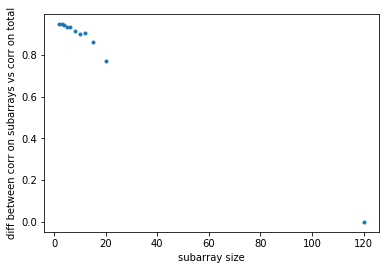

In [121]:
x = [2,3,4,5,6,8,10,12,15,20,120]
y = [abs(cov_ab - covariate(a,b, subarr_size=i)[0]) for i in x]
plt.plot(x,y,'.', label='mean')
plt.ylabel('diff between corr on subarrays vs corr on total')
plt.xlabel('subarray size')
y

In [71]:
randarr = np.random.normal(loc=mean, scale=0.2, size=720)

In [90]:
array =[]
for arr in np.split(randarr,20): array.append(randarr.mean() - arr.mean())
array=np.array(array)

In [93]:
array.mean()

array([-0.04442086, -0.01401929,  0.01861138,  0.00974887,  0.02029346,
       -0.04913738,  0.00410619, -0.00527306, -0.03096396, -0.02247355,
        0.0064991 ,  0.00665203, -0.03777625,  0.04204859,  0.03324069,
        0.02979986,  0.0419336 ,  0.03124362, -0.00984606, -0.03026697])

### Appendix

Confirming the equation for covariance.

In [61]:
arr = np.random.normal(loc=2,scale=0.1, size=120)
arr2 = np.random.normal(loc=4, scale=0.2, size=120)
split1 = np.split(arr,20)
split2 = np.split(arr2,20)

In [63]:
cov(arr,arr2) - np.array([cov(subarr1,subarr2) for (subarr1,subarr2) in zip(split1,split2)]).mean()

0.00030133025571172923

In [65]:
np.array([subarr1.mean()*subarr2.mean() for (subarr1,subarr2) in zip(split1,split2)]).mean() - arr.mean()*arr2.mean()

0.0003013302557111075

### Random Attempts

From the above formula, we find the variance:
$ VAR(<E(X_{i})><E(Y_{i})> - E(X)E(Y)) = \frac{n}{m} \big( (\sigma _{X}E(Y))^{2} + (\sigma_{Y}E(X))^{2} + \frac{n}{m}(\sigma_{X} \sigma_{Y})^{2} \big) + (\sigma_{X} \sigma_{Y})^{2} + (\sigma_{X}E(Y))^{2} + (\sigma_{Y}E(X))^{2}$

Lemma 1: If X,Y are two independent variables, then 

$VAR(XY) = VAR(X)VAR(Y) + VAR(X)E(Y)^{2} + VAR(Y)E(X)^{2} $